In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import readdy

In [3]:
data_dir = "/home/chris/workspace/data/workshop/filaments"
out_file = os.path.join(data_dir, "filaments.h5")

In [20]:
system = readdy.ReactionDiffusionSystem(
    box_size=[20., 20., 20.], 
    periodic_boundary_conditions=[True, True, True],
    unit_system=None)

system.add_species("substrate", 0.1)
system.add_topology_species("head", 0.1)
system.add_topology_species("core", 0.1)
system.add_topology_species("tail", 0.1)

system.topologies.add_type("filament")

system.topologies.configure_harmonic_bond("head", "core", force_constant=100, length=1.)
system.topologies.configure_harmonic_bond("core", "core", force_constant=100, length=1.)
system.topologies.configure_harmonic_bond("core", "tail", force_constant=100, length=1.)

triplets = [
    ("head", "core", "core"),
    ("core", "core", "core"),
    ("core", "core", "tail"),
    ("head", "core", "tail")
]
for (t1, t2, t3) in triplets:
    system.topologies.configure_harmonic_angle(
        t1, t2, t3, force_constant=50., 
        equilibrium_angle=180. / 180. * np.pi)


system.topologies.add_spatial_reaction(
    "attach: filament(head) + (substrate) -> filament(core--head)",
    rate=5.0, radius=1.5
)

def rate_function(topology):
    """
    if the topology has at least (head, core, tail)
    the tail shall be removed with a fixed probability per time
    """
    vertices = topology.get_graph().get_vertices()
    if len(vertices) > 3:
        return 0.05
    else:
        return 0.

def reaction_function(topology):
    """
    find the tail and remove it,
    and make the adjacent core particle the new tail
    """
    recipe = readdy.StructuralReactionRecipe(topology)
    vertices = topology.get_graph().get_vertices()

    tail_idx = None
    adjacent_core_idx = None
    for v in vertices:
        if topology.particle_type_of_vertex(v) == "tail":
            adjacent_core_idx = v.neighbors()[0].get().particle_index
            tail_idx = v.particle_index

    recipe.separate_vertex(tail_idx)
    recipe.change_particle_type(tail_idx, "substrate")
    recipe.change_particle_type(adjacent_core_idx, "tail")

    return recipe


#system.topologies.add_structural_reaction("detach", "filament", reaction_function=reaction_function, 
#                                          rate_function=rate_function)

In [21]:
simulation = system.simulation("SingleCPU")

In [22]:
simulation.output_file = out_file
simulation.record_trajectory(stride=100)
simulation.observe.topologies(stride=100)

In [23]:
init_top_pos = np.array([
    [ 1. ,0. ,0.],
    [ 0. ,0. ,0.],
    [-1. ,0. ,0.]
])
top = simulation.add_topology("filament", ["head", "core", "tail"], init_top_pos)
top.get_graph().add_edge(0, 1)
top.get_graph().add_edge(1, 2)

In [24]:
n_substrate = 300
origin = np.array([-10., -10., -10.])
extent = np.array([20., 20., 20.])
simulation.add_particles("substrate", positions=np.random.uniform(size=(n_substrate,3)) * extent + origin)

In [25]:
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.run(400000, 5e-3)

  0%|          | 50/40000 [00:00<01:20, 496.59it/s]

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (true, true, true)
 - box size = (20, 20, 20)
 - particle types:
     * Topology particle type "tail" with D=0.1
     * Topology particle type "core" with D=0.1
     *  particle type "substrate" with D=0.1
     * Topology particle type "head" with D=0.1
 - topology potential configuration:
     - bonds (3):
         - Bonds for particle types core and tail:
             * Harmonic bond with force constant 100 and length 1
         - Bonds for particle types head and core:
             * Harmonic bond with force constant 100 and length 1
         - Bonds for particle types core and core:
             * Harmonic bond with force constant 100 and length 1
     - angles (4):
             * Harmonic angle with force constant 50 and equilibrium angle 3.14159
             * Harmonic angle with force constant 50 and equilibrium angle 3.14159
             * Harmonic angle with force constant 50 and equ

100%|██████████| 40000/40000 [01:20<00:00, 497.40it/s]


In [26]:
traj = readdy.Trajectory(out_file)

/home/chris/miniconda3/envs/tutorials/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [27]:
traj.convert_to_xyz(particle_radii={"head": 0.5, "core": 0.5, "tail": 0.5, "substrate": 0.5})

In [28]:
!vmd -e /home/chris/workspace/data/workshop/filaments/filaments.h5.xyz.tcl > /dev/null

/home/chris/misc/vmd/lib/vmd/vmd_LINUXAMD64: /usr/lib/x86_64-linux-gnu/libGL.so.1: no version information available (required by /home/chris/misc/vmd/lib/vmd/vmd_LINUXAMD64)


In [29]:
# chain length
times, topology_records = traj.read_observable_topologies()

In [30]:
chain_length = [ len(tops[0].particles) for tops in topology_records ]

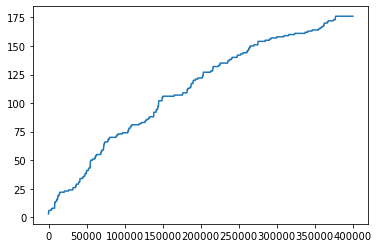

In [31]:
plt.plot(times, chain_length)

In [32]:
times = np.array(times)*5e-3
chain_length = np.array(chain_length)

popt [2.20447653e+02 7.84070262e-04]
pcov [[ 1.80730613e-01 -1.10059458e-06]
 [-1.10059458e-06  6.98557047e-12]]


/home/chris/miniconda3/envs/tutorials/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


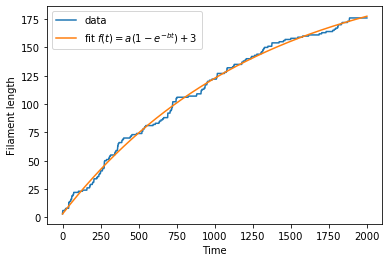

In [33]:
import scipy.optimize as so

def func(t, a, b):
    return a*(1. - np.exp(-b * t)) + 3.

popt, pcov = so.curve_fit(func, times, chain_length)

print("popt", popt)
print("pcov", pcov)

f = lambda t: func(t, popt[0], popt[1])

#plt.figure(figsize=(4,3))
plt.plot(times, chain_length, label="data")
plt.plot(times, f(times), label=r"fit $f(t)=a(1-e^{-bt})+3$")
plt.xlabel("Time")
plt.ylabel("Filament length")
plt.legend()
#plt.gcf().tight_layout()
#plt.savefig("fusion_diff_"+str(diff)+".pdf")
plt.show()